# Capstone Project

## Data Modeling and Evaluation

In [187]:
#Import libraries
import pandas as pd
import numpy as np
import gensim.downloader as api
from gensim.models import word2vec
from transformers import pipeline
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, silhouette_samples
import time;
import logging;
import multiprocessing;
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [188]:
#Read in 'twitter_df'
twitter_df = pd.read_csv("../dataset/twitter_df.csv")

In [189]:
#Check shape
twitter_df.shape

(22153, 8)

In [190]:
#Drop Unnamed: 0 column
twitter_df.drop(['Unnamed: 0'], axis=1, inplace=True)

**Remove tweets that contain 'RT' and tweets that were repeated to make sure there is no cluster overlapping**

In [191]:
#Delete the rows that contains 'RT' and reset the index
twitter_df = twitter_df[~twitter_df['tweets'].str.contains('RT')].reset_index(drop=True)

In [192]:
# originaltweets = originaltweets

In [193]:
#Get the rows where number of words in the tweet are > 5
twitter_df = twitter_df[twitter_df['cleaned_tweets'].str.count(' ')  > 5]

In [194]:
#Check the number of duplicated rows
len(twitter_df[twitter_df.duplicated("tweets")])

509

In [195]:
#Drop duplicates
twitter_df =twitter_df.drop_duplicates(subset=['cleaned_tweets'], keep='first').reset_index(drop=True)

### Word2Vec

In [196]:
#Convert tweet into a list of words
X = twitter_df['cleaned_tweets'].str.split().tolist()
len(X)

7111

In [197]:
#https://medium.com/ml2vec/using-word2vec-to-analyze-reddit-comments-28945d8cee57
#Initialize Word2Vec Model to build vocabulary out of tweets
# Minimum word count to keep a word which is repeated 100 times in the vocabulary
model = word2vec.Word2Vec(X,min_count=100);

In [198]:
#Check the vocabulary
model.wv.key_to_index.items()

dict_items([('work', 0), ('remote', 1), ('home', 2), ('working', 3), ('office', 4), ('time', 5), ('employee', 6), ('apply', 7), ('business', 8), ('team', 9), ('engineer', 10), ('check', 11), ('company', 12), ('hiring', 13), ('make', 14), ('remotely', 15), ('help', 16), ('full', 17), ('need', 18), ('looking', 19), ('opportunity', 20), ('join', 21), ('want', 22), ('today', 23), ('learn', 24), ('people', 25), ('read', 26), ('senior', 27), ('life', 28), ('software', 29), ('tip', 30), ('developer', 31), ('best', 32), ('manager', 33), ('worker', 34), ('pandemic', 35), ('like', 36), ('many', 37), ('back', 38), ('hybrid', 39), ('online', 40), ('free', 41), ('share', 42), ('role', 43), ('find', 44), ('job', 45), ('know', 46), ('year', 47), ('service', 48), ('customer', 49), ('meeting', 50), ('start', 51), ('take', 52), ('stay', 53), ('great', 54), ('week', 55), ('post', 56), ('product', 57), ('world', 58), ('anywhere', 59), ('virtual', 60), ('marketing', 61), ('experience', 62), ('thing', 63), 

In [199]:
#Code written by Caroline
def get_avg_vec(text):
    try:
        # make a list of only the words in the document that are in the word2vec vocabulary
        valid_words = [word for word in text if word in model.wv.key_to_index]
        if len(valid_words) == 0:
            return np.zeros(shape=(100,))
        else:
            # return average word vector, for words in the document that exist in the vocab
            return np.mean([model.wv.get_vector(word) for word in valid_words], axis=0)
    except AttributeError:
        return np.zeros(shape=(100,))

In [200]:
#Get Mean Vectors for the given data
avg_vecs = [get_avg_vec(doc) for doc in X]

In [201]:
#Convert the avg_vecs into. a dataframe
vec_df = pd.DataFrame(avg_vecs)

In [202]:
#Concatenate 'twitter_df' and 'vec_df'
df_vec = pd.concat([twitter_df, vec_df], axis=1).reset_index(drop=True)

In [203]:
#Display first five rows after Concatenation
df_vec.head()

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,user_location_cleaned,polarity,0,1,2,...,90,91,92,93,94,95,96,97,98,99
0,1416181616846811137,2021-07-16 23:43:03+00:00,🏡 #RemoteWork is on the rise &amp; slowly beco...,rise slowly becoming normal mean need remote t...,"New York, NY",US,1,0.092423,0.042721,0.061060,...,0.272182,0.211014,0.061671,0.083693,0.178988,0.030558,0.083759,-0.056646,-0.030969,-0.050809
1,1416181380279635970,2021-07-16 23:42:07+00:00,Opportunity to join a fantastic team at a hi-t...,opportunity join fantastic team tech fast pace...,London | New York,US,1,0.066943,0.036022,0.120044,...,0.284550,0.220301,0.044658,0.078216,0.169209,0.012390,0.075852,-0.069246,-0.057309,-0.059494
2,1416181225979473920,2021-07-16 23:41:30+00:00,Good news for #JobSeekers open to #RemoteWork!...,good news open excellent report remote advert ...,Sydney | Hong Kong | Singapore,HK,1,0.080606,0.042911,0.097951,...,0.278587,0.209657,0.042799,0.070188,0.157770,0.011445,0.083270,-0.070629,-0.054611,-0.066995
3,1416180231350759425,2021-07-16 23:37:33+00:00,🚑 These are the tools that will save your #Rem...,tool save google meet tool created love want know,"Duluth, GA",US,0,0.097439,0.054810,0.032654,...,0.277930,0.205673,0.058255,0.089136,0.188740,0.040488,0.087430,-0.053861,-0.019731,-0.046469
4,1416178372296675331,2021-07-16 23:30:09+00:00,Would you consider outsourcing a project to so...,would consider outsourcing project someone nev...,Global,None,0,0.101491,0.043847,0.055635,...,0.276816,0.221309,0.055035,0.077971,0.181448,0.028940,0.089450,-0.060947,-0.017486,-0.050624


In [204]:
#Consider only Vectorized columns 
vec_col = df_vec.columns[7:]
vec_col_names = df_vec[vec_col]

In [205]:
#Scale the Vectorized Columns
X_vec=vec_col_names
sc = StandardScaler()
X_vec_sc = sc.fit_transform(X_vec)
X_vec_sc[0:1]

array([[ 0.26708678, -0.28478846,  0.02592553,  0.40723737,  0.24585126,
        -0.14291811,  0.09198522,  0.12741715, -0.13650467, -0.17973097,
         0.17973241, -0.18404824, -0.038878  ,  0.30756752,  0.0676374 ,
         0.29056004,  0.0893237 , -0.143043  ,  0.22558364, -0.147749  ,
         0.11953632, -0.50531938,  0.09564086, -0.26564878,  0.21942346,
         0.00457537, -0.12118003, -0.02758387, -0.15715251,  0.22361306,
         0.25908885,  0.13296057,  0.1009973 , -0.06093439,  0.05585972,
         0.14574731, -0.30130911, -0.32096742,  0.17067563, -0.22765789,
         0.26065993, -0.30265436, -0.33993014, -0.00820246,  0.07732664,
         0.24091685, -0.09782817, -0.14018313,  0.03521882,  0.21008958,
         0.45862357, -0.36198466, -0.13903091,  0.15129841,  0.1756872 ,
         0.27192122,  0.08206653,  0.25987098, -0.1802028 ,  0.21039768,
        -0.10187096,  0.0606708 ,  0.06289448,  0.15069099, -0.27340978,
         0.15088864,  0.29789971,  0.12212615, -0.0

In [206]:
#https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
#Find the optimal 'n_clusters'  between 3 and 16 using 'Elbow Method'
Sum_of_squared_distances_word2vec = []
for i in range(3, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_vec_sc)
    Sum_of_squared_distances_word2vec.append(kmeans.inertia_)

### CountVectorizer

In [207]:
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
#https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
#Instantiate and fit the CountVectorizer
cv = CountVectorizer(max_features=3500) 
X_cv = cv.fit_transform(twitter_df['cleaned_tweets'].astype('U'))  

In [208]:
# Convert X_cv into a dataframe
X_cv_df = pd.DataFrame(X_cv.toarray(), columns = cv.get_feature_names())

In [209]:
# Check shape of X_cv_df
print(f'Shape of X_cv_df: {X_cv_df.shape}')

Shape of X_cv_df: (7111, 3500)


In [210]:
#Concatenate 'twitter_df' and 'X_cv_df'
df_cv = pd.concat([twitter_df, X_cv_df], axis=1).reset_index(drop=True)

In [211]:
#Display first three rows after Concatenation
df_cv.head(3)

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,user_location_cleaned,polarity,ability,able,absence,...,yesterday,yoga,york,young,younger,youtube,zero,zoho,zone,zoom
0,1416181616846811137,2021-07-16 23:43:03+00:00,🏡 #RemoteWork is on the rise &amp; slowly beco...,rise slowly becoming normal mean need remote t...,"New York, NY",US,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1416181380279635970,2021-07-16 23:42:07+00:00,Opportunity to join a fantastic team at a hi-t...,opportunity join fantastic team tech fast pace...,London | New York,US,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1416181225979473920,2021-07-16 23:41:30+00:00,Good news for #JobSeekers open to #RemoteWork!...,good news open excellent report remote advert ...,Sydney | Hong Kong | Singapore,HK,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [212]:
#Consider only Vectorized columns 
cv_col = df_cv.columns[7:]
cv_col_names = df_cv[cv_col]

In [213]:
#Scale the Vectorized Columns
X_cv=cv_col_names
sc = StandardScaler()
X_cv_sc = sc.fit_transform(X_cv)
X_cv_sc[0:1]

array([[-0.06173659, -0.07623514, -0.01591204, ..., -0.02054409,
        -0.05836702, -0.09165462]])

In [214]:
#Find the optimal 'n_clusters'  between 3 and 16 using 'Elbow Method'
Sum_of_squared_distances_cv = []
for i in range(3, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_cv_sc)
    Sum_of_squared_distances_cv.append(kmeans.inertia_)

### Tfidf Vectorizer

In [215]:
#Instantiate and fit the TFIDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(twitter_df['cleaned_tweets'].astype('U')) 

In [216]:
# Convert X_tfidf into a dataframe
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns = tfidf.get_feature_names())

In [217]:
# Check shape of X_tfidf_df
print(f'Shape of X_tfidf_df: {X_tfidf_df.shape}')

Shape of X_tfidf_df: (7111, 5000)


In [218]:
#Concatenate 'twitter_df' and 'X_tfidf_df'
df_tfidf = pd.concat([twitter_df, X_tfidf_df], axis=1).reset_index(drop=True)

In [219]:
#Display first three rows after Concatenation
df_tfidf.head(3)

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,user_location_cleaned,polarity,ababa,abandon,ability,...,zealand,zealander,zebra,zero,zoho,zombie,zone,zoom,zooming,zubair
0,1416181616846811137,2021-07-16 23:43:03+00:00,🏡 #RemoteWork is on the rise &amp; slowly beco...,rise slowly becoming normal mean need remote t...,"New York, NY",US,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1416181380279635970,2021-07-16 23:42:07+00:00,Opportunity to join a fantastic team at a hi-t...,opportunity join fantastic team tech fast pace...,London | New York,US,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1416181225979473920,2021-07-16 23:41:30+00:00,Good news for #JobSeekers open to #RemoteWork!...,good news open excellent report remote advert ...,Sydney | Hong Kong | Singapore,HK,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
#Consider only Vectorized columns 
tfidf_col = df_tfidf.columns[7:]
tfidf_col_names = df_tfidf[tfidf_col]

In [221]:
#Scale the Vectorized Columns
X_tfidf=tfidf_col_names
sc = StandardScaler()
X_tfidf_sc = sc.fit_transform(X_tfidf)
X_tfidf_sc[0:1]

array([[-0.01676766, -0.01676178, -0.06046767, ..., -0.09038836,
        -0.01651335, -0.01185947]])

In [222]:
#Find the optimal 'n_clusters'  between 3 and 16 using 'Elbow Method'
Sum_of_squared_distances_tfidf = []
for i in range(3, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_tfidf_sc)
    Sum_of_squared_distances_tfidf.append(kmeans.inertia_)

## Evaluation

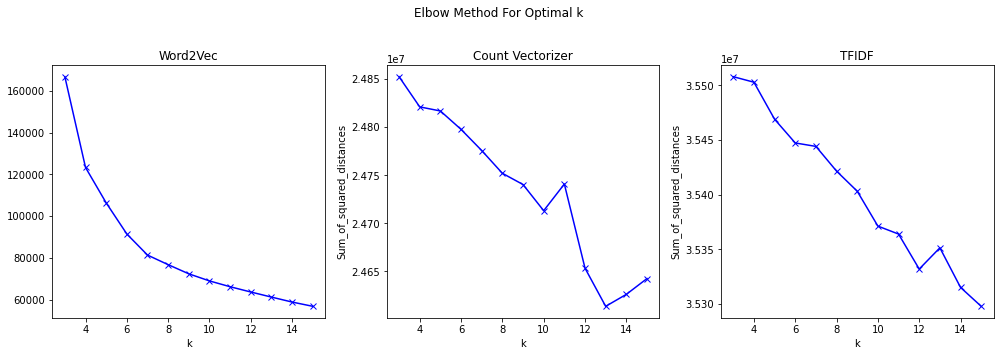

In [223]:
#Plot the 'Elbow Method For Optimal k'
plt.subplots(1, 3, figsize=(14,5))
plt.suptitle('Elbow Method For Optimal k \n')

plt.subplot(1, 3, 1)
plt.plot(range(3, 16), Sum_of_squared_distances_word2vec, 'bx-')
plt.xlabel('k')
plt.title('Word2Vec')

plt.subplot(1, 3, 2)
plt.plot(range(3, 16), Sum_of_squared_distances_cv, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances');
plt.title('Count Vectorizer')

plt.subplot(1,3,3)
plt.plot(range(3, 16), Sum_of_squared_distances_tfidf, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances');
plt.title('TFIDF')
plt.tight_layout()

- **According to the Elbow Method, if the plot looks like an arm, then the elbow on the arm is optimal k.**
- **By looking at the above plots,Word2Vec plot looks like an arm and hence going ahead with Word2Vec data**
- **Optimal number of clusters would be '4'**

In [224]:
#Initialise K-means
km_vec = KMeans(n_clusters=4, random_state=42)
km_vec.fit(X_vec_sc)

KMeans(n_clusters=4, random_state=42)

In [225]:
#Create a column 'km' and store the cluster labels
df_vec['km']=km_vec.labels_

In [226]:
#Check the number of rows on each cluster
df_vec['km'].value_counts()

3    3606
1    2214
0    1092
2     199
Name: km, dtype: int64

In [227]:
#Get silhouette_score to check how cluster has performed
ss = silhouette_score(X_vec_sc,km_vec.labels_)
ss

0.35893277325395495

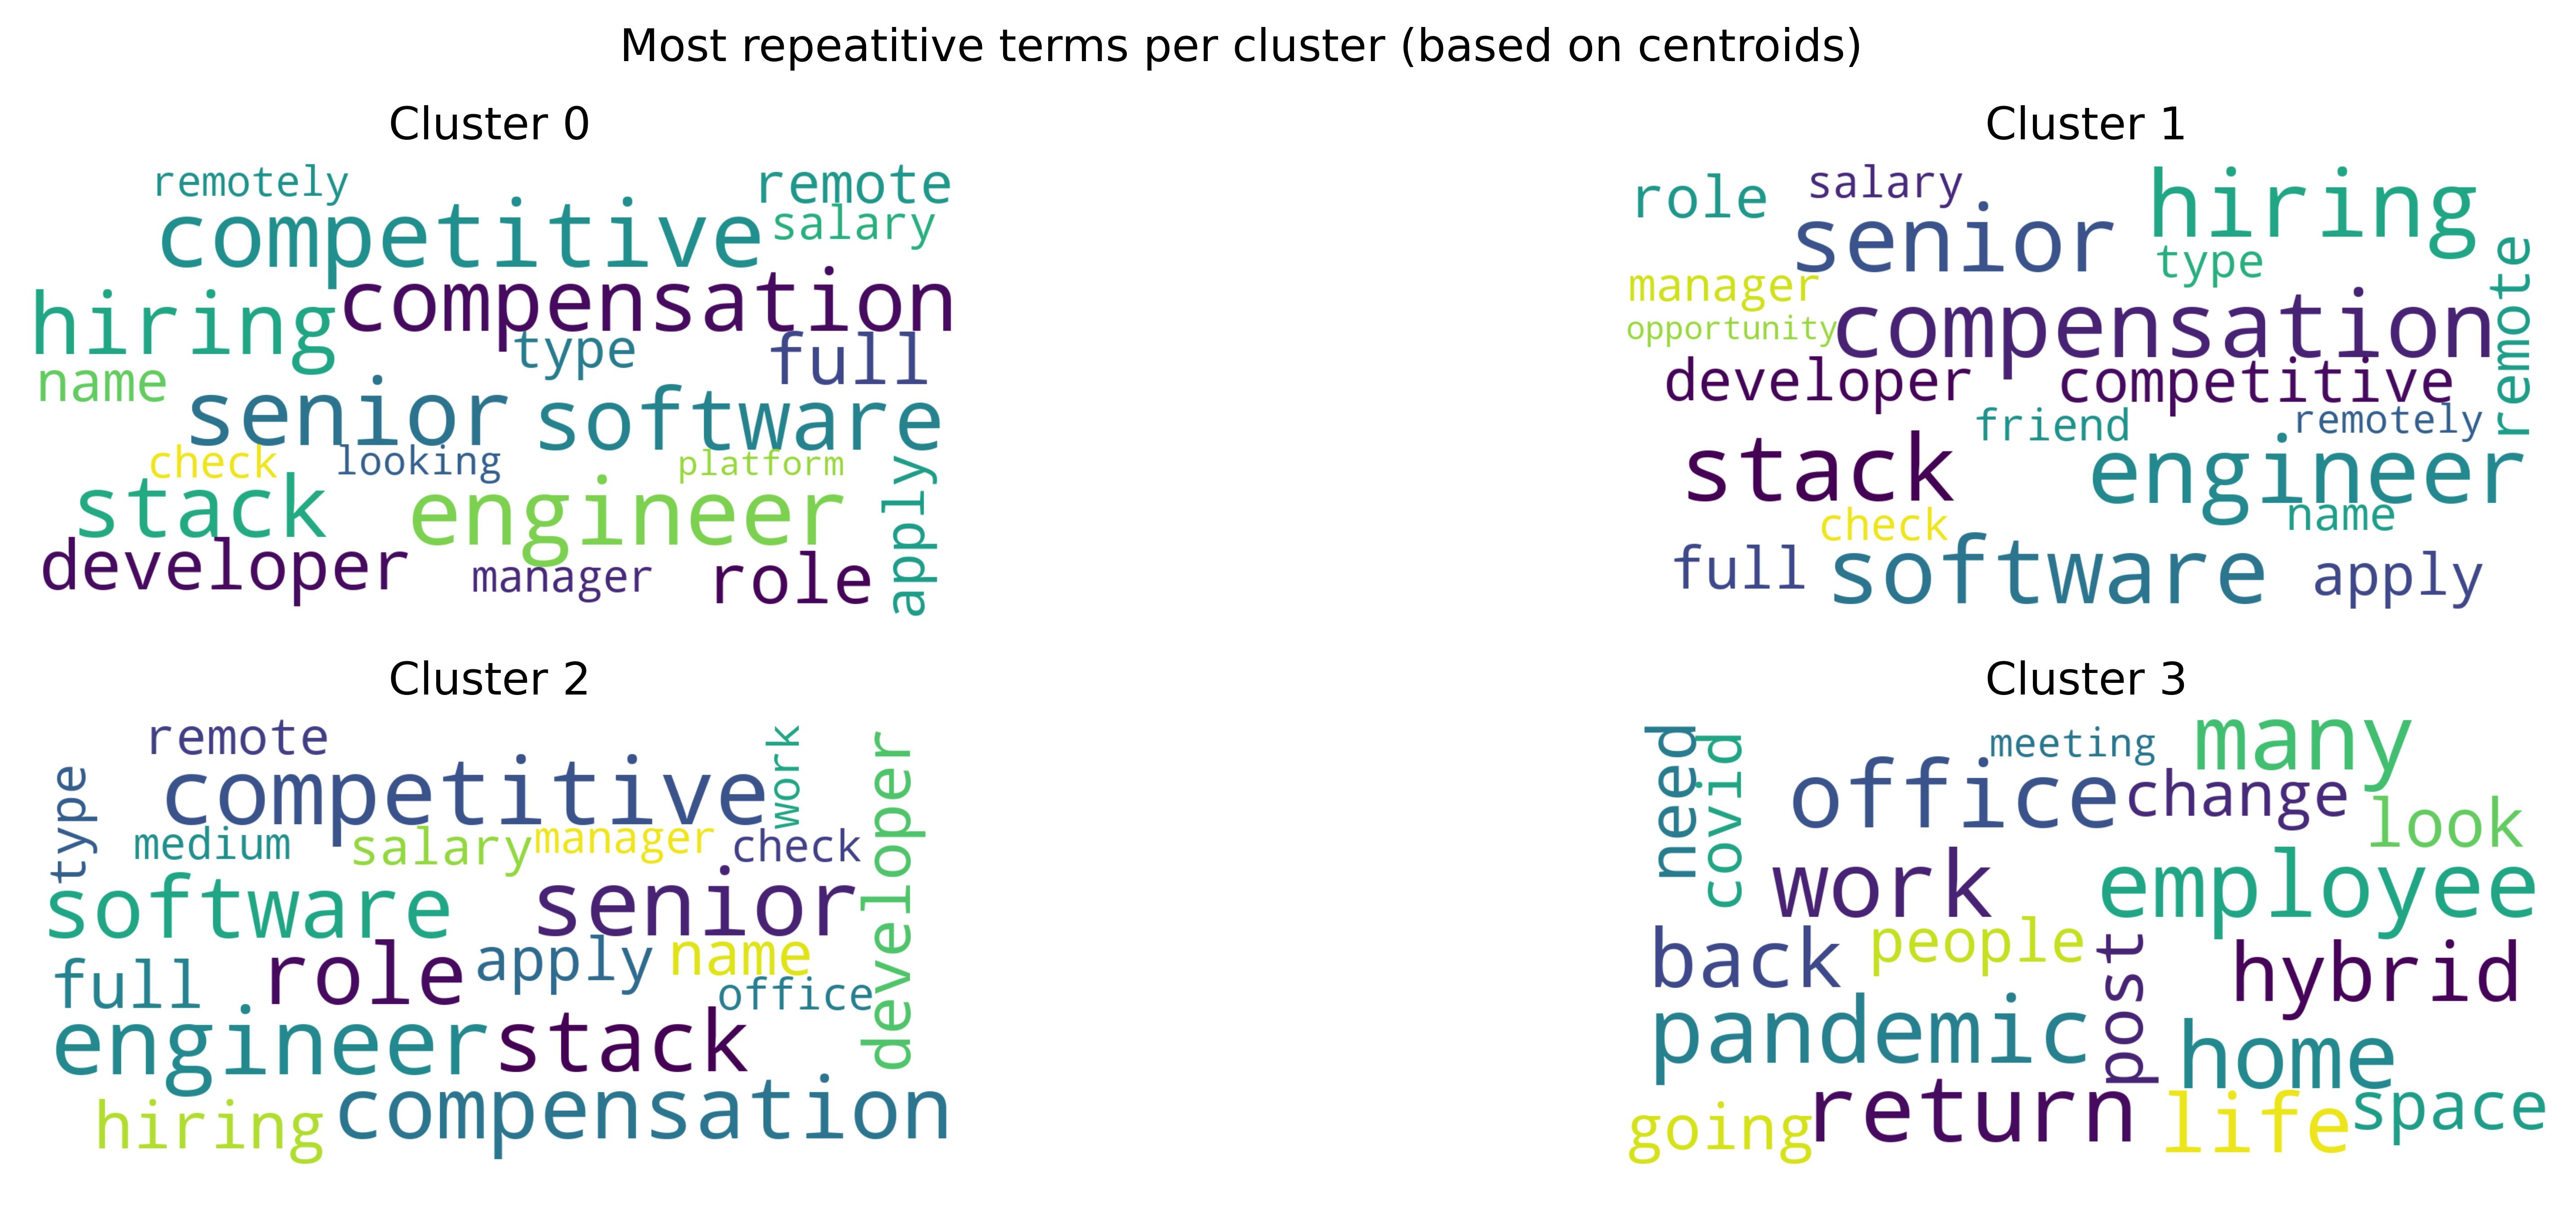

In [228]:
plt.subplots(2,2, figsize=(14,5),dpi=600)
plt.suptitle('Most repeatitive terms per cluster (based on centroids)')
for i in range(4):
    top_words = ""
    most_representative = model.wv.most_similar([km_vec.cluster_centers_[i]], topn=20)
    for t in most_representative:
        top_words += f"{t[0]} "
    wordcloud = WordCloud( background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(top_words);
    plt.subplot(2,2,i+1)
    plt.imshow(wordcloud, interpolation="bilinear");
    plt.axis('off');
    plt.title(f"Cluster {i}");

In [229]:
#https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
#Print the tweets in each cluster to check for a pattern
def cluster_pattern(cluster,count):
    most_representative_docs = np.argsort(np.linalg.norm(X_vec_sc - km_vec.cluster_centers_[cluster], axis=1))
    for d in most_representative_docs[:count]:
        print(df_vec['tweets'][d])
        print("-------------")

In [230]:
cluster_pattern(0,10)

Dash is looking to hire a Senior Software Engineer 🔥 • Remote Anywhere • Apply now to be among the first candidates 👇

#javascript #blockchain #tendermint #techjobs #softwaredevelopment #remotejobs #workfromhome #GoRemote

https://t.co/VSh91dFfGu
-------------
We’re looking for people to #JoinTheHerd! #RemoteWork positions available: Senior Software Engineer (full-stack), Platform Solutions: Remote https://t.co/mjduknX7dS
-------------
Senior Product Manager, Design Systems

🌍 REMOTE
🏢 mailchimp

#jobs #okjob #Hiring #NowHiring
#remote #remotejobs #remotework
#JobSearch #JobHunt #JobOpening

https://t.co/bXboClESMe
-------------
👋 Nira is hiring remotely for a Software Engineer 🧰 Distributed Systems | Big Data | 100% Remote.
    
    #RemoteJob #RemoteWork  #BackendDeveloper 
    Apply now! 👇
    https://t.co/MELGsgwwpQ🧰-distributed-systems-big-data-100-remote-760897
-------------
👋 Superformula is hiring remotely for a Node.js/Terraform/AWS Backend Engineer, Digital Products (remote).

In [231]:
cluster_pattern(1,5)

We’re growing our team! We have open roles in Product, Marketing, Sales, Technology and Finance! If you want to make a difference at a growing tech company, find your future here! 

https://t.co/zibSjm2U0j 

#remotework #hiring #techjobs
-------------
Remote work is a spectrum.  Learn what it takes to create a great remote culture at your company.  

Save 50% on the Remote Work Master Class: https://t.co/mi2cgC73R2

Now includes free companion Kindle book.

#remotework #remoteworking
-------------
🏅Today’s featured article looks at the remote work skills you can include on your CV to help you gain a hiring managers attention. 

🆓 Sign up for FREE to read the article and more: https://t.co/SW14gXK5xW

#jobsearch #wfh #worklife #careers #CV #remotework #remoteworking https://t.co/0WQL3WytJN
-------------
Our latest blog post features tips from enpact Program Manager Matthias Loker about the best Zoom games to play with teams and the remote collaboration tools we highly recommend.

https:

In [232]:
cluster_pattern(2,10)

This Harvard Professor Reveals The Secret Sauce For #RemoteWork - And It Has Nothing To Do With Zoom. (Forbes) https://t.co/A7gT657qYh https://t.co/2dv3zpyjGC
-------------
So the order of creatures ruling my lawn every morning:
1) Rabbits
2) Herons
3) Quail
#workfromhome
-------------
Up Now Will Chase’s New Credit Card Permanently Replace a Popular Card? https://t.co/soSqizmAJO via @AJBCSurveys #workfromhome #jury-research https://t.co/K8XA2jzKjR
-------------
When you permit your present results to control your thoughts, your income cannot improve. 

#WorkFromHome #homebusiness #MLM #networkmarketing #Hemp https://t.co/pRaeOGoQxN
-------------
Neuilly-sur-Seine | Bilingual Nanny | End of August 
Job title: Neuilly-sur-Seine | Bilingu... 
https://t.co/xPeAfB3H7w 
#computer #freelancers #internet #IT #Jobs #makemoneyonline #marketing #sales #website #workathome #workfromhome
https://t.co/xPeAfB3H7w
-------------
New research paper in Language Policy, #workfromhome: how multi-level mar

In [233]:
cluster_pattern(3,15)

Now that it's #FreedomDay today 🥳 we think it's a good time to look back and reflect on some of the things we learned while working from home over the last year ✌ What did you learn? Let us know! 👇👇

#WorkFromHome #BackToTheOffice #WolfPack https://t.co/C1O4NjeuYw https://t.co/6L5etCOTGa
-------------
Employees must embrace digital tools &amp; change the way they work to keep up with digital  changes
https://t.co/m7SiL0CqCh

#revenuewithoutrestrictions
.
.
.

#ITO #BPO #IT #technology #cloud #analytics #data #AI  #digitaltransformation #digitalliteracy #skills #workfromhome
-------------
What are your rights if you’d rather work from home for good, or at least adopt a half-and-half hybrid system? 💻📱

Citizens Advice has answered the need-to-know questions &gt; https://t.co/mFOaj3MjGR

#LifeAfterLockdown #WorkFromHome #HealthAndSafety #Wellbeing https://t.co/jyU8FT4NwT
-------------
2021 is the year that the world redefines what it means to collaborate. Whether you work in an office, vi

**Findings from analyzing both thw words and tweets per cluster**
- **Cluster_1 is about Remote Job Postings.Work Skills required for people are interested to work from home**
- **Did not find any pattern in Cluster_2 as most of the tweets had more hashtags than the text,here is no sync between the text and the hashtags used**
- **Cluster_3 is  about the impact of work from home which is what the project is about**
- **Cluster_0 is about remote job openings in IT Sector.Most of the job postings are for Front End Developer,BackendDeveloper,Full-Stack Developer**

In [237]:
cluster_pattern(3,30)

Now that it's #FreedomDay today 🥳 we think it's a good time to look back and reflect on some of the things we learned while working from home over the last year ✌ What did you learn? Let us know! 👇👇

#WorkFromHome #BackToTheOffice #WolfPack https://t.co/C1O4NjeuYw https://t.co/6L5etCOTGa
-------------
Employees must embrace digital tools &amp; change the way they work to keep up with digital  changes
https://t.co/m7SiL0CqCh

#revenuewithoutrestrictions
.
.
.

#ITO #BPO #IT #technology #cloud #analytics #data #AI  #digitaltransformation #digitalliteracy #skills #workfromhome
-------------
What are your rights if you’d rather work from home for good, or at least adopt a half-and-half hybrid system? 💻📱

Citizens Advice has answered the need-to-know questions &gt; https://t.co/mFOaj3MjGR

#LifeAfterLockdown #WorkFromHome #HealthAndSafety #Wellbeing https://t.co/jyU8FT4NwT
-------------
2021 is the year that the world redefines what it means to collaborate. Whether you work in an office, vi